# Channel Flow

This test validates the coupling of the momentum equations and the pressure coupling.
The domain is a 2D channel with wall on the top and bottom, and a momentum inlet on
the left and a outlet (zero gradient) on the outlet.

In laminar flow the velocity profile in the channel will assume a parabolic profile.

moin


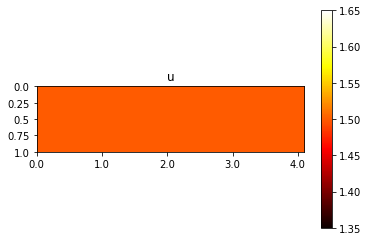

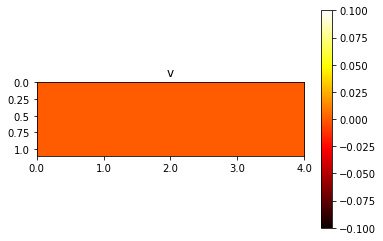

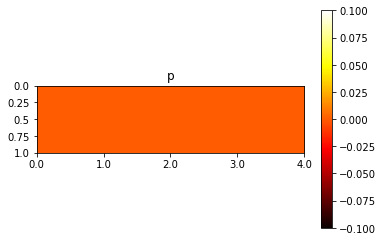

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/MultiphaseTestBench')
import Manager as mptb
from fieldAccess import *

import numpy as np
#import MeshConfig

nx = 4
ny = 1

inletVelocity = 1.5

geom = mptb.createGeometry( 'rectangle', [nx,ny] )
mesh = mptb.createMesh( geom, res=10 )

# make just a list, give a name as optional parameter to flow model
# make this a flowmodels constructor with kwargs here and then remove simulation instance
myFlowModels = {
    'u' : mptb.TransportModels.staggeredTransport_u,
    'v' : mptb.TransportModels.staggeredTransport_v,
    'p' : mptb.PressureModels.Pressure
}

passiveFields = {}

mptb.initialize(flowmodels=myFlowModels, mesh=mesh, geometry=geom, passiveFields=passiveFields )

u=mptb.getField('u')
v=mptb.getField('v')
p=mptb.getField('p')

# relates to viscosity:
u.govModel.setDiffusionCoefficient(1e-2)
v.govModel.setDiffusionCoefficient(1e-2)

u.data.fill(inletVelocity)
mptb.defineBoundaryCondition(field=u, boundaryName='top', type='fixedValue', value=0)
mptb.defineBoundaryCondition(field=u, boundaryName='bottom', type='fixedValue', value=0)
mptb.defineBoundaryCondition(field=u, boundaryName='right', type='zeroGradient')
mptb.defineBoundaryCondition(field=u, boundaryName='left', type='fixedValue', value=inletVelocity)

v.data.fill(0.0)
mptb.defineBoundaryCondition(field=v, boundaryName='top', type='fixedValue', value=0)
mptb.defineBoundaryCondition(field=v, boundaryName='bottom', type='fixedValue', value=0)
mptb.defineBoundaryCondition(field=v, boundaryName='left', type='fixedValue', value=0 )
mptb.defineBoundaryCondition(field=v, boundaryName='right', type='fixedValue', value=0)

p.data.fill(0)
mptb.defineBoundaryCondition(field=p, boundaryName='top', type='freeFlow')
mptb.defineBoundaryCondition(field=p, boundaryName='bottom', type='freeFlow')
mptb.defineBoundaryCondition(field=p, boundaryName='left', type='freeFlow' )
mptb.defineBoundaryCondition(field=p, boundaryName='right', type='constantPressure', value=0)

# underRelaxation
alphaP = 0.3
alphaUV = 0.7


# make a max function when calculating the d coefficients. some a_p values might be extremely low, such that the corresp d values become hughe

# making a more sophisticated initial guess:
# u.data[internal] = mptb.solve(u)[internal]
# v.data[internal] = mptb.solve(v)[internal]

#
# for i in range(10):
#
#     u.data = mptb.solve(u)
#     v.data = mptb.solve(v)

    # pc = mptb.solve(p)
    # p.data += pc
    #
    # u.data[internal_u] += p.govModel.d_u[internal_u] * ( pc[west] - pc[east] )
    # v.data[internal_v] += p.govModel.d_v[internal_v] * ( pc[south] - pc[north])



# preparing the simple loop:
for i in range(0):

    uOld = u.data
    vOld = v.data

    uNew = mptb.solve(u)
    vNew = mptb.solve(v)
    pc = mptb.solve(p)

    # correcting pressure
    p.data += alphaP*pc

    totInFlow = mptb.calcFlowRate(field=u, boundaryName='left')
    totOutFlow = mptb.calcFlowRate(field=u, boundaryName='right')

    # correcting internal:    what about the left side?
    uNew[internal_u] += p.govModel.d_u[internal_u] * ( pc[west] - pc[east] )
    vNew[internal_v] += p.govModel.d_v[internal_v] * ( pc[south] - pc[north] )
    uNew[boundary_east] = uOld[boundary_nb1_east] * totInFlow/totOutFlow

    u.data = alphaU*uNew + (1-alphaU)*uOld
    #v.data = alphaV*vNew + (1-alphaV)*vOld

    # correcting boundaries:  Can I not set them algorithmically? this is not nice
    # correcting boundaries a second time:
    totInFlow = mptb.calcFlowRate(field=u, boundaryName='left')
    totOutFlow = mptb.calcFlowRate(field=u, boundaryName='right')

    u.data[boundary_east] = u.data[boundary_nb1_east] * totInFlow/totOutFlow
#    v.data[boundary_east] = v.data[boundary_nb1_east] * totInFlow/totOutFlow

    # totInFlow = mptb.calcFlowRate(field=u, boundaryName='left')
    # totOutFlow = mptb.calcFlowRate(field=u, boundaryName='right')
    #
    #print((totInFlow-totOutFlow)/totInFlow)


# totInFlow = mptb.calcFlowRate(field=u, boundaryName='left')
# totOutFlow = mptb.calcFlowRate(field=u, boundaryName='right')
#
# print("inflow:\t", totInFlow )
# print("outflow:\t", totOutFlow )

mptb.display(u,mesh,'u')
mptb.display(v,mesh,'v')
mptb.display(p,mesh,'p')

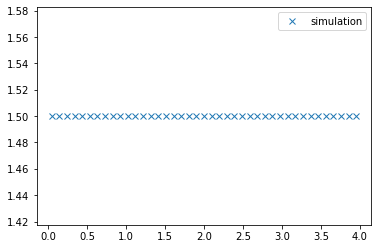

[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5]


In [2]:

# post-processing:
import numpy as np
import matplotlib.pyplot as plt

nbcellsX = mesh.cells_x
cellSpacing = mesh.uniformSpacing
LenX = geom.lenX

xSim = np.linspace(0+0.5*cellSpacing,LenX-0.5*cellSpacing,nbcellsX+1)
ySim = u.data[ny//2 ,:]

# xTheo = np.linspace(0,LenX, 100)
# S = np.ones(len(xTheo))*heatSource
# yTheo = tempDistr(xTheo)

ax = plt.gca()
ax.plot(xSim, ySim, 'x', label='simulation')
#ax.plot(xTheo, yTheo, label='theoretical')

plt.legend()
plt.show()

print(ySim)


In [ ]:
# shutting the interpreter down, so I can a fresh instance next time.
# my modules are automatically checked for updates
import os
os._exit(00)